# Lab 4

# Libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Functions
Some useful defined functions that you can use and modify

In [2]:
def print_classification(y_test, y_pred):
    from sklearn.metrics import classification_report, confusion_matrix
    # Classification Report
    print(classification_report(y_test, y_pred))
    
    # Plot
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize = (5,3))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

In [3]:
def feature_importance(features, importance):
    df_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
    df_importance['Impact'] = ['Positive' if x > 0 else 'Negative' for x in df_importance['Importance']]
    df_importance.sort_values(by = 'Importance', ascending = False, inplace = True)

    plt.figure(figsize = (6,8))
    sns.barplot(data = df_importance, x = 'Importance', y = 'Feature', hue = 'Impact', hue_order = ['Negative', 'Positive'])
    plt.title('Feature Importance')
    plt.show()

In [4]:
def get_profit(y_test, y_pred, revenue, cost):
    from sklearn.metrics import confusion_matrix 
    cm = confusion_matrix(y_test, y_pred)
    total_cost = (cm[0][1] + cm[1][1]) * cost
    total_revenue = (cm[1][1]) * revenue
    profit = total_revenue - total_cost
    return profit

# 1. Import Data
Start by importing the `customer_data.xlsx` file into a pandas DataFrame

In [5]:
df = pd.read_excel('customer_data.xlsx')

Print the first 5 rows

In [6]:
df.head()

,Custid,Year_Birth,Gender,Education,Marital_Status,Dependents,Income,Dt_Customer,Rcn,Frq,Mnt,Clothes,Kitchen,SmallAppliances,HouseKeeping,Toys,NetPurchase,CatPurchase,Recomendation,Response
0,1003,1991,M,Graduation,NaN,1,29761.20,2014-05-27,69,11,45.76,32,19,24,1,24,59,41,3,0
1,1004,1956,M,Master,Married,1,98249.55,2013-07-21,10,26,923.52,60,10,19,6,5,35,65,5,0
2,1006,1983,F,PhD,Together,1,23505.30,2013-10-30,65,14,58.24,47,2,48,2,1,67,33,4,0
3,1007,1970,F,Graduation,Single,1,72959.25,2012-12-06,73,18,358.80,71,7,13,1,8,46,54,4,0
4,1009,1941,F,Graduation,Married,0,114973.95,2013-10-30,75,30,1457.04,38,9,35,9,9,17,83,5,0


How many rows and columns does our dataset have?

In [7]:
df.shape

(2500, 20)

Knowing the cost per contact (4€) and the revenue per positive answer (50€), what was the total profit of the last Marketing campaing? 

In [8]:
revenue = 50
cost = 4

total_revenue = df['Response'].sum() * revenue
total_cost = len(df['Response']) * cost

profit = total_revenue - total_cost
print('Profit: {} €'.format(profit))

Profit: -1250 €


## 1.1. Split Data

Since we are expert Data Scientists and we know the dangers of overfitting, let's split our data like so:
* 80% Trainning
* 20% Testing

_Since we are dealing with a binary classification problem, remember to keep the same proportion of positive responses in each subset!_

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, stratify = df['Response'], test_size = 0.2, random_state = 0)

Check the dimensionality of each subset

In [10]:
print(train.shape)
print(test.shape)

(2000, 20)
(500, 20)


Check the response rate in each subset

In [11]:
print(train['Response'].mean())
print(test['Response'].mean())

0.07
0.07


# 2. EDA: Exploratory Data Analysis

### 2.1. Data Types
Start the EDA by checking the data types in our data

In [12]:
train.dtypes

Custid                      int64
Year_Birth                  int64
Gender                     object
Education                  object
Marital_Status             object
Dependents                  int64
Income                    float64
Dt_Customer        datetime64[ns]
Rcn                         int64
Frq                         int64
Mnt                       float64
Clothes                     int64
Kitchen                     int64
SmallAppliances             int64
HouseKeeping                int64
Toys                        int64
NetPurchase                 int64
CatPurchase                 int64
Recomendation               int64
Response                    int64
dtype: object

### 2.2. Data summary
For each data type `numerical`, `object`, and `datetime`, let's see some summary statistics

In [13]:
# Numerical
train.describe()

,Custid,Year_Birth,Dependents,Income,Rcn,Frq,Mnt,Clothes,Kitchen,SmallAppliances,HouseKeeping,Toys,NetPurchase,CatPurchase,Recomendation,Response
count,2000.000000,2000.000000,2000.000000,1942.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,5962.347500,1966.880500,0.704000,73929.687899,63.787000,19.847000,648.220560,50.997500,6.947500,28.232500,6.924000,6.886000,42.039000,57.961000,3.937500,0.070000
std,2913.195583,17.104225,0.456605,28873.182630,71.088708,10.918021,676.397877,23.403405,7.945018,12.460099,7.727812,7.951642,18.291959,18.291959,1.146408,0.255211
min,1004.000000,1937.000000,0.000000,10500.000000,0.000000,3.000000,8.320000,2.000000,0.000000,2.000000,0.000000,0.000000,5.000000,12.000000,1.000000,0.000000
25%,3376.250000,1952.000000,0.000000,50654.362500,27.000000,10.000000,67.340000,34.000000,2.000000,19.000000,2.000000,1.000000,28.000000,43.000000,3.000000,0.000000
50%,5957.500000,1966.000000,1.000000,74456.025000,53.000000,17.000000,365.040000,51.000000,4.000000,27.000000,4.000000,4.000000,45.000000,55.000000,4.000000,0.000000
75%,8511.000000,1981.000000,1.000000,97320.300000,78.000000,28.000000,1066.000000,70.000000,9.000000,37.000000,9.000000,10.000000,57.000000,72.000000,5.000000,0.000000
max,10997.000000,1997.000000,1.000000,144204.900000,549.000000,56.000000,2993.120000,98.000000,68.000000,69.000000,54.000000,77.000000,88.000000,95.000000,6.000000,1.000000


In [14]:
# Object
train.describe(include = 'object')

,Gender,Education,Marital_Status
count,2000,1993,1986
unique,2,5,5
top,F,Graduation,Married
freq,1532,989,733


In [15]:
# Datetime
train.describe(include = 'datetime')

,Dt_Customer
count,2000
unique,665
top,2012-09-25 00:00:00
freq,8
first,2012-07-29 00:00:00
last,2014-06-29 00:00:00


Look at the following boxplot. What can you conclude on the customers preference?

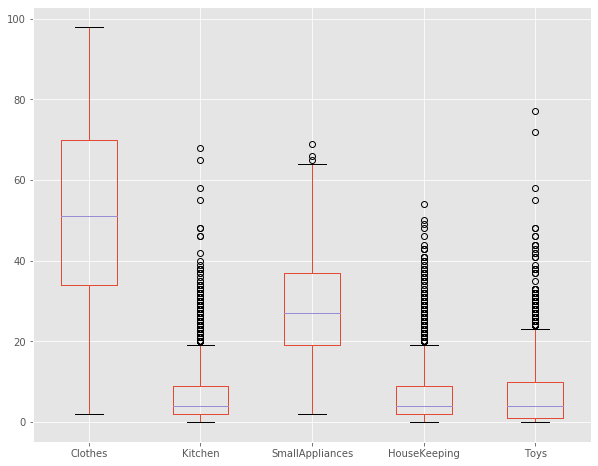

In [16]:
plt.figure(figsize = (10, 8))
train[['Clothes','Kitchen','SmallAppliances','HouseKeeping','Toys']].boxplot()
plt.show()

Using a seaborn countplot, check the distribution of categories for `Gender`, `Education`, and `Marital_Status`

https://seaborn.pydata.org/generated/seaborn.countplot.html

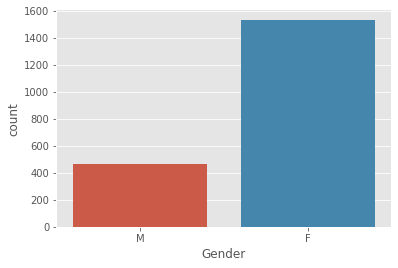

In [17]:
sns.countplot(x = 'Gender', data = train)

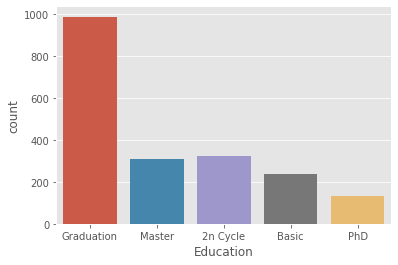

In [18]:
sns.countplot(x = 'Education', data = train)

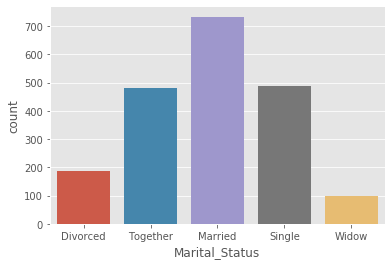

In [19]:
sns.countplot(x = 'Marital_Status', data = train)

### 2.3. Missing Values
Missing data is always a No-No. How many missings do we have per feature?

In [20]:
train.isna().sum()

Custid              0
Year_Birth          0
Gender              0
Education           7
Marital_Status     14
Dependents          0
Income             58
Dt_Customer         0
Rcn                 0
Frq                 0
Mnt                 0
Clothes             0
Kitchen             0
SmallAppliances     0
HouseKeeping        0
Toys                0
NetPurchase         0
CatPurchase         0
Recomendation       0
Response            0
dtype: int64

Check them visually!

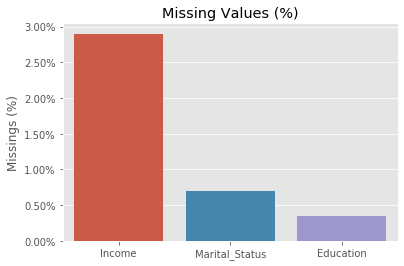

In [21]:
df_na = pd.DataFrame(train.isna().sum()/train.shape[0],
                        columns = ['Missings (%)']).sort_values(by = 'Missings (%)', ascending = False)
df_na = df_na[df_na['Missings (%)'] > 0].copy()

plt.figure(figsize = (6,4))
ax = sns.barplot(data = df_na, x = df_na.index, y = 'Missings (%)' )
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title('Missing Values (%)')
plt.show()

### 2.4. Correlation
Display the correlation between all features

In [22]:
train.corr()

,Custid,Year_Birth,Dependents,Income,Rcn,Frq,Mnt,Clothes,Kitchen,SmallAppliances,HouseKeeping,Toys,NetPurchase,CatPurchase,Recomendation,Response
Custid,1.000000,-0.026678,-0.016030,0.023342,0.011245,0.006780,0.007626,0.018445,-0.014396,-0.018158,-0.000787,-0.008994,-0.027084,0.027084,0.010930,0.023993
Year_Birth,-0.026678,1.000000,0.465557,-0.932564,0.201991,-0.754271,-0.798688,-0.240524,0.270927,-0.055399,0.252198,0.278272,0.777769,-0.777769,-0.396761,-0.292261
Dependents,-0.016030,0.465557,1.000000,-0.442448,0.088538,-0.549154,-0.614991,0.272804,-0.126324,-0.279465,-0.130854,-0.114839,0.590923,-0.590923,-0.302947,-0.277147
Income,0.023342,-0.932564,-0.442448,1.000000,-0.206443,0.802358,0.838364,0.218179,-0.241252,0.051177,-0.235392,-0.250417,-0.734172,0.734172,0.421265,0.338185
Rcn,0.011245,0.201991,0.088538,-0.206443,1.000000,-0.211066,-0.170151,-0.067240,0.041595,0.045499,0.021748,0.064212,0.148902,-0.148902,-0.086474,-0.038139
Frq,0.006780,-0.754271,-0.549154,0.802358,-0.211066,1.000000,0.977657,0.092929,-0.151136,0.105776,-0.131995,-0.158407,-0.641627,0.641627,0.526963,0.420003
Mnt,0.007626,-0.798688,-0.614991,0.838364,-0.170151,0.977657,1.000000,0.036930,-0.123658,0.160683,-0.106967,-0.131149,-0.745474,0.745474,0.530100,0.439678
Clothes,0.018445,-0.240524,0.272804,0.218179,-0.067240,0.092929,0.036930,1.000000,-0.662162,-0.634964,-0.658931,-0.649764,0.057791,-0.057791,0.016346,0.043666
Kitchen,-0.014396,0.270927,-0.126324,-0.241252,0.041595,-0.151136,-0.123658,-0.662162,1.000000,0.093235,0.406856,0.409997,0.034987,-0.034987,-0.059293,-0.060359
SmallAppliances,-0.018158,-0.055399,-0.279465,0.051177,0.045499,0.105776,0.160683,-0.634964,0.093235,1.000000,0.123187,0.092458,-0.183865,0.183865,0.071445,0.049153


Can you represent the correlation visually?

https://seaborn.pydata.org/generated/seaborn.heatmap.html

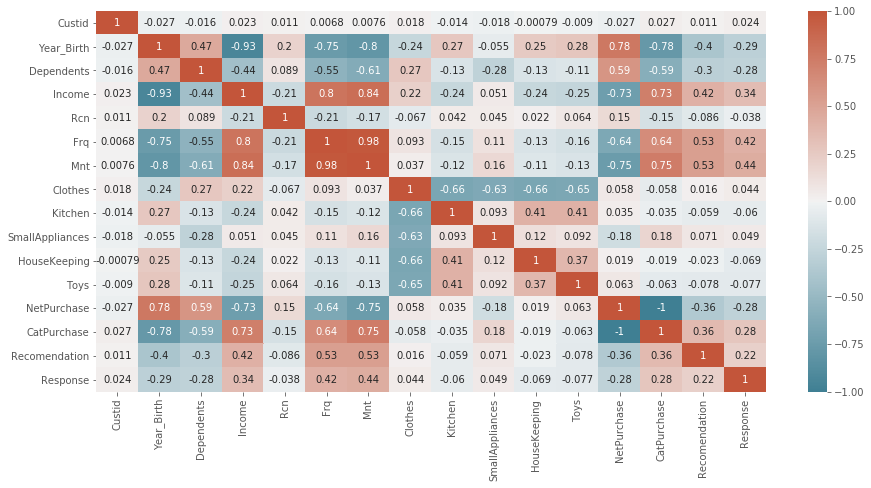

In [23]:
# cmap = sns.diverging_palette(220, 20, as_cmap=True) optional colors
cmap = sns.diverging_palette(220, 20, as_cmap=True)

plt.figure(figsize = (15,7))
sns.heatmap(train.corr(), annot = True, cmap = cmap)
plt.show()

`Mnt` and `Frq` seem very highly correlated. Display this relationship with a scatterplot. What can you conclude?

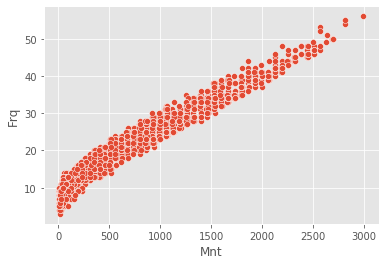

In [24]:
sns.scatterplot(data = train, x = 'Mnt', y = 'Frq')

# 3. Data Preprocessing
In this section we will transform our data to better fit an analytical model. Remember that all decisions have to be made based on the __Training__ set but replicated on the __Testing__ set.

### 3.1. Drop Correlated Features
Let's look at the pairs with over 90% correlation and drop one of the features. They are basically giving the same information.

In [25]:
# Frq, CatPurchase, Year_Birth

cols_to_drop = ['Frq', 'CatPurchase', 'Year_Birth']

train.drop(columns = cols_to_drop, inplace = True)
test.drop(columns = cols_to_drop, inplace = True)

In [26]:
train.shape

(2000, 17)

### 3.2. Fix Missing Values
Since there are some missing values, let's use a simple strategy of imputing the missings using the median value of numerical features. For features of type Object, use the most frequent category (mode).

In [27]:
# Numerical
train.fillna(train.median(), inplace = True)

In [28]:
test.fillna(train.median(), inplace = True)

In [29]:
# Object
train.fillna(train.select_dtypes('object').mode().iloc[0], inplace = True)
test.fillna(train.select_dtypes('object').mode().iloc[0], inplace = True)

In [30]:
# Confirm you solved the problem
test.isna().sum()

Custid             0
Gender             0
Education          0
Marital_Status     0
Dependents         0
Income             0
Dt_Customer        0
Rcn                0
Mnt                0
Clothes            0
Kitchen            0
SmallAppliances    0
HouseKeeping       0
Toys               0
NetPurchase        0
Recomendation      0
Response           0
dtype: int64

### 3.3. New Features / Encoding
Usually in a problem, we go beyond the features that already exist in our data. In fact, the features we create based on our business knowledge will probably be more important for predictions than the original ones. Having said this, create the following variables:
* __Days as Customer__ - Nr. of days as customer
* __Female__ - 1 if customer is Female, 0 if Male
* __High_Educ__ - 1 if customer has high education (Graduation, Master, or PhD)
* __Marital Status__ (One-Hot-Encoding) - One dummy binary feature for each category

In [31]:
# Days as Customer

now = datetime.datetime.now()

train['Days_as_customer'] = (now - train['Dt_Customer']).dt.days

In [32]:
test['Days_as_customer'] = (now - test['Dt_Customer']).dt.days

In [33]:
train[['Dt_Customer', 'Days_as_customer']].head(3)

,Dt_Customer,Days_as_customer
1558,2013-01-10,2995
233,2012-11-17,3049
192,2012-11-06,3060


In [34]:
# Female

train['Female'] = train['Gender'].replace({'F': 1, 'M': 0})
test['Female'] = test['Gender'].replace({'F': 1, 'M': 0})

In [35]:
train[['Gender', 'Female']].head(3)

,Gender,Female
1558,M,0
233,F,1
192,F,1


In [36]:
# High Educ
train['High_Educ'] = 0
train.loc[train['Education'].isin(['Graduation', 'Master', 'PhD']), 'High_Educ'] = 1

test['High_Educ'] = 0
test.loc[test['Education'].isin(['Graduation', 'Master', 'PhD']), 'High_Educ'] = 1

In [37]:
train[['Education', 'High_Educ']].head(5)

,Education,High_Educ
1558,Graduation,1
233,Graduation,1
192,Master,1
979,2n Cycle,0
696,Graduation,1


In [38]:
# Marital Status -> One-Hot-Encoding (with prefix MS)

dummies = pd.get_dummies(train['Marital_Status'], prefix = 'MS', drop_first = True)

train = pd.concat([train, dummies], axis = 1)

In [39]:
dummies = pd.get_dummies(test['Marital_Status'], prefix = 'MS', drop_first = True)

test = pd.concat([test, dummies], axis = 1)

In [40]:
train[['Marital_Status', 'MS_Married', 'MS_Single', 'MS_Together', 'MS_Widow']].head()

,Marital_Status,MS_Married,MS_Single,MS_Together,MS_Widow
1558,Divorced,0,0,0,0
233,Together,0,0,1,0
192,Married,1,0,0,0
979,Married,1,0,0,0
696,Together,0,0,1,0


In [41]:
test.shape

(500, 24)

Drop the initial variables: `Dt_Customer`, `Gender`, `Education`, and `Marital_Status`

In [42]:
cols_to_drop = ['Dt_Customer', 'Gender', 'Education', 'Marital_Status']

train.drop(columns = cols_to_drop, inplace = True)
test.drop(columns = cols_to_drop, inplace = True)

### 3.4. Split data into X and Y
We are almost done with preprocessing our data. To make things easier, let's divide our data into independent (what we use to predict) and dependent (what we want to predict) features:
* __x_train__ - all training data except `Custid` and `Response`
* __y_train__ - training `Response`
* __x_test__ - all testing data except `Custid` and `Response`
* __y_test__ - testing `Response`

In [43]:
# If you missed any previous step, use this checkpoint to import the dataset we created until now.

#train = pd.read_excel('customer_data_checkpoint.xlsx', sheet_name = 'train', index_col = 0)
#test = pd.read_excel('customer_data_checkpoint.xlsx', sheet_name = 'test', index_col = 0)

In [44]:
x_train = train.drop(columns = ['Custid', 'Response'])
y_train = train['Response']

x_test = test.drop(columns = ['Custid', 'Response'])
y_test = test['Response']

In [45]:
x_train.head()

,Dependents,Income,Rcn,Mnt,Clothes,Kitchen,SmallAppliances,HouseKeeping,Toys,NetPurchase,Recomendation,Days_as_customer,Female,High_Educ,MS_Married,MS_Single,MS_Together,MS_Widow
1558,1,94801.35,8,984.88,56,15,23,5,1,32,5,2995,0,1,0,0,0,0
233,0,100834.65,27,1732.64,50,2,33,7,8,12,5,3049,1,1,0,0,1,0
192,1,68761.35,68,313.04,86,1,12,1,1,47,3,3060,1,1,1,0,0,0
979,1,35596.05,358,20.80,11,26,22,8,33,53,4,2807,0,0,1,0,0,0
696,0,98932.05,29,1062.88,39,4,36,9,12,32,5,2665,0,1,0,0,1,0


### 3.5. Normalize
Since we have features in different scale, it is common to normalize the data to avoid future problems. Let's try the Min-Max scaler that fits all values between 0 and 1 in the __x_train__ and __x_test__ subsets.

In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Train

x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns = x_train.columns, index = x_train.index)

# Test
x_test_scaled = scaler.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns = x_test.columns, index = x_test.index)


Check the first 5 rows of the __x_train__ subset

In [47]:
x_test_scaled.head()

,Dependents,Income,Rcn,Mnt,Clothes,Kitchen,SmallAppliances,HouseKeeping,Toys,NetPurchase,Recomendation,Days_as_customer,Female,High_Educ,MS_Married,MS_Single,MS_Together,MS_Widow
2377,1.0,0.449057,0.120219,0.244599,0.437500,0.073529,0.597015,0.166667,0.000000,0.265060,0.4,0.345714,1.0,1.0,1.0,0.0,0.0,0.0
539,0.0,0.416498,0.165756,0.118118,0.906250,0.014706,0.059701,0.037037,0.025974,0.469880,0.6,0.312857,1.0,1.0,0.0,0.0,1.0,0.0
2471,1.0,0.572720,0.078324,0.416725,0.333333,0.176471,0.417910,0.203704,0.168831,0.397590,0.8,0.911429,1.0,0.0,1.0,0.0,0.0,0.0
853,1.0,0.180064,0.165756,0.016376,0.364583,0.264706,0.373134,0.240741,0.077922,0.385542,0.6,0.864286,1.0,1.0,0.0,1.0,0.0,0.0
2155,1.0,0.191310,0.174863,0.003833,0.781250,0.000000,0.268657,0.037037,0.000000,0.662651,0.4,0.255714,0.0,1.0,1.0,0.0,0.0,0.0


# 4. Model
Now the cool part!

### 4.1. The Old Way
Using the old method (sending the offer to every customer), estimate the profit you would get in the testing subset. 

In [48]:
y_pred = [1] * len(y_test)

In [49]:
profit_old = get_profit(y_test = y_test, y_pred = y_pred, revenue = revenue, cost = cost)
print('Total Profit: {} €'.format(profit_old))

Total Profit: -250 €


### 4.2. Logistic Regression
Using a Logistic Regression, train a model in the training set and predict the response in the testing set. Then, calculate some main performance measures (Accuracy, Precision, Recall, F1-Score), print the feature importance and estimate the profit.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
model = LogisticRegression(random_state = 0)

model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)

In [52]:
profit_reg = get_profit(y_test = y_test, y_pred = y_pred, revenue = revenue, cost = cost)
print('Total Profit: {} €'.format(profit_reg))

Total Profit: 276 €


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       465
           1       1.00      0.17      0.29        35

    accuracy                           0.94       500
   macro avg       0.97      0.59      0.63       500
weighted avg       0.95      0.94      0.92       500



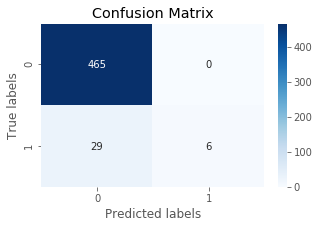

In [53]:
print_classification(y_test = y_test, y_pred = y_pred)

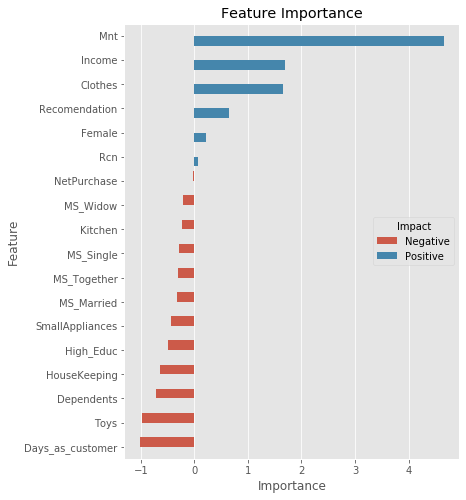

In [54]:
feature_importance(features = x_train.columns, importance = model.coef_[0])

Build a barplot that displays the profit on the testing set by using the Old method and a Logistic Regression

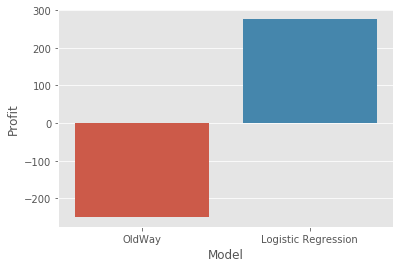

In [55]:
results = pd.DataFrame({'Model': ['OldWay', 'Logistic Regression'],
                        'Profit': [profit_old, profit_reg]})

sns.barplot(data = results ,x = 'Model', y = 'Profit')
plt.show()

# 5. EXTRA
What happens if we try a different model? A Decision Tree for example.

In [56]:
from sklearn.tree import DecisionTreeClassifier

### 5.1. Decision Tree

In [57]:
model = DecisionTreeClassifier(random_state=0)

model = model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       465
           1       0.28      0.31      0.29        35

    accuracy                           0.89       500
   macro avg       0.61      0.63      0.62       500
weighted avg       0.90      0.89      0.90       500



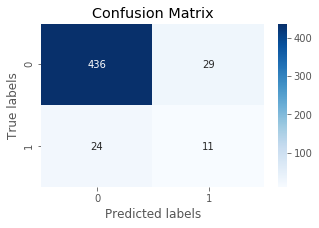

In [58]:
print_classification(y_test, y_pred)

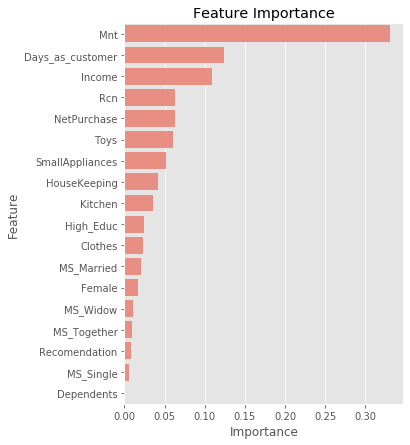

In [59]:
features = x_train_scaled.columns
importance = model.feature_importances_

df_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
df_importance.sort_values(by = 'Importance', ascending = False, inplace = True)

plt.figure(figsize = (5,7))
sns.barplot(data = df_importance, x = 'Importance', y = 'Feature', color = 'salmon')
plt.title('Feature Importance')
plt.show()

### 5.2. Decision Tree with feature selection

In [60]:
# Using the most important features

cols = ['Mnt', 'Days_as_customer', 'Income', 'Rcn', 'NetPurchase', 'Toys', 
        'SmallAppliances', 'HouseKeeping', 'Kitchen', 'High_Educ']

model = DecisionTreeClassifier(random_state=0)

model = model.fit(x_train_scaled[cols], y_train)

y_pred = model.predict(x_test_scaled[cols])

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       465
           1       0.30      0.40      0.35        35

    accuracy                           0.89       500
   macro avg       0.63      0.67      0.64       500
weighted avg       0.91      0.89      0.90       500



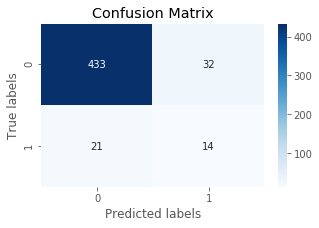

In [61]:
print_classification(y_test, y_pred)

### 5.3. Compare Models

In [62]:
profit_dict = {}
# Old way
y_pred = [1] * len(y_test)
profit_dict['Old Way'] = get_profit(y_test = y_test, y_pred = y_pred, revenue = revenue, cost = cost)

# Logistic
y_pred = LogisticRegression(random_state=0).fit(x_train_scaled, y_train).predict(x_test_scaled)
profit_dict['Logistic Regression'] = get_profit(y_test = y_test, y_pred = y_pred, revenue = revenue, cost = cost)

# Decision Tree
y_pred = DecisionTreeClassifier(random_state=0).fit(x_train_scaled, y_train).predict(x_test_scaled)
profit_dict['Decision Tree'] = get_profit(y_test = y_test, y_pred = y_pred, revenue = revenue, cost = cost)

# Decision Tree with selection
cols = ['Mnt', 'Days_as_customer', 'Income', 'Rcn', 'NetPurchase', 'Toys','SmallAppliances', 'HouseKeeping', 'Kitchen', 'High_Educ']
y_pred = DecisionTreeClassifier(random_state=0).fit(x_train_scaled[cols], y_train).predict(x_test_scaled[cols])
profit_dict['Decision Tree (w selection)'] = get_profit(y_test = y_test, y_pred = y_pred, revenue = revenue, cost = cost)

In [63]:
models = pd.DataFrame.from_dict(profit_dict, orient = 'Index').reset_index()
models.columns = ['Model', 'Profit']
print(models.columns)

Index(['Model', 'Profit'], dtype='object')


Knowing the `models` DataFrame has 2 columns: _Model_ and _Profit_ , can you draw a barplot that ilustrates each Model and Profit?

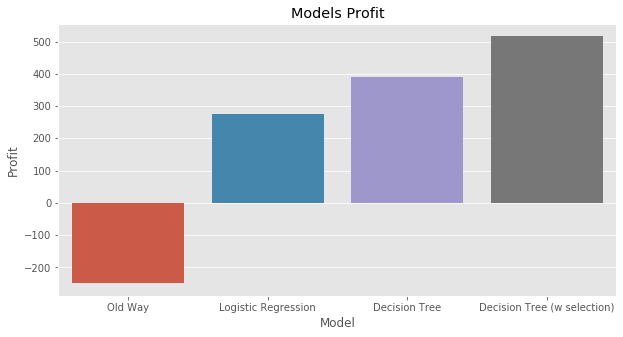

In [64]:
plt.figure(figsize = (10, 5))
sns.barplot(data = models, x = 'Model', y = 'Profit')
plt.title('Models Profit')
plt.show()